## Load Data

In [ ]:
import dask.dataframe as dd

# Load the parquet file into a Dask DataFrame
df = dd.read_parquet('checkpoint_datacleaning2')

df.head()

,abstract_inverted_index,apc_list,apc_paid,authors_count,cited_by_api_url,cited_by_count,cited_by_percentile_year,concepts_count,corresponding_author_ids,corresponding_institution_ids,...,type_id,updated,updated_date,versions,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging
0,None,None,None,0,https://api.openalex.org/works?filter=cites:W4...,0,"{'min': 0, 'max': 66}",6,[],[],...,https://openalex.org/work-types/article,2025-01-17T01:18:43.637758,2025-01-17T01:18:43.637758,[],<NA>,<NA>,<NA>,NaN,True,NaN
1,None,None,None,1,https://api.openalex.org/works?filter=cites:W2...,0,"{'min': 0, 'max': 63}",7,['https://openalex.org/A5101726172'],['https://openalex.org/I4210135744'],...,https://openalex.org/work-types/article,2025-01-17T11:40:31.631339,2025-01-17T11:40:31.631339,[],Diet and metabolism studies,Medicine,Health Sciences,0.9972,True,NaN
2,None,None,None,1,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",7,['https://openalex.org/A5016168871'],[],...,https://openalex.org/work-types/article,2025-01-17T17:49:01.433374,2025-01-17T17:49:01.433374,[],Pharmacogenetics and Drug Metabolism,"Pharmacology, Toxicology and Pharmaceutics",Life Sciences,0.9786,True,NaN
3,None,None,None,2,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",5,[],[],...,https://openalex.org/work-types/article,2025-01-17T09:04:08.282477,2025-01-17T09:04:08.282477,[],Traditional Chinese Medicine Studies,Medicine,Health Sciences,0.9960,True,NaN
4,None,None,None,3,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",11,[],[],...,https://openalex.org/work-types/article,2025-01-17T14:44:13.147750,2025-01-17T14:44:13.147750,[],Autophagy in Disease and Therapy,Medicine,Health Sciences,0.9991,True,NaN


In [2]:
# prompt: get the dimension of df (which is a dask dataframe)

n_rows, n_cols = df.shape
n_rows = n_rows.compute()

print(f"Dask DataFrame shape: {n_rows} rows × {n_cols} columns")


Dask DataFrame shape: 1846795 rows × 42 columns


## Check the results of the classifier

In [ ]:
df['is_aging'].unique().compute()

,is_aging
0,0.0
0,NaN
0,1.0


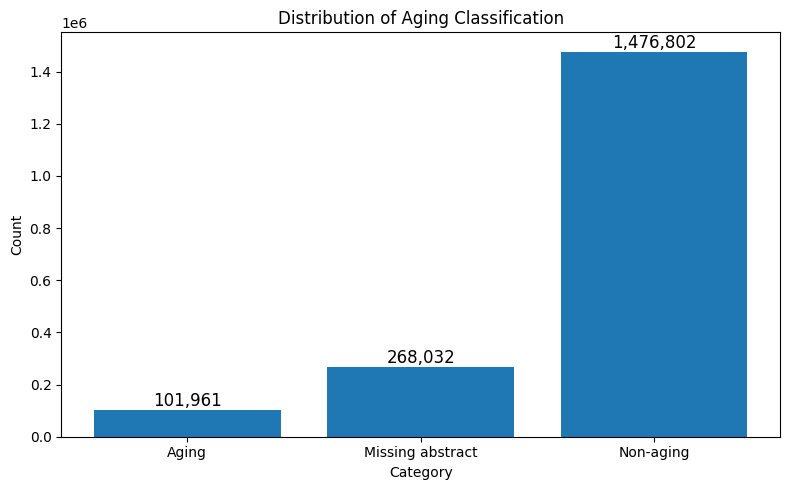

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate value counts, including NaN
value_counts = df['is_aging'].value_counts(dropna=False).compute()

# Map the labels
label_map = {
    0: 'Aging',
    1: 'Non-aging',
    float('nan'): 'Missing abstract'  # NaN will be handled below
}

# Replace NaN key with string label
labels = []
counts = []
for k, v in value_counts.items():
    if pd.isna(k):
        labels.append('Missing abstract')
    elif k == 0:
        labels.append('Aging')
    elif k == 1:
        labels.append('Non-aging')
    else:
        labels.append(str(k))
    counts.append(v)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)

# Add exact count on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{count:,}', ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Aging Classification')
plt.ylabel('Count')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


In [ ]:
import ast
import re

def process_inverted_index_string(inverted_index_str):
    # Step 1: Convert the string to a Python dictionary safely
    inverted_index = ast.literal_eval(inverted_index_str)

    # Step 2: Build a list of (position, word) pairs
    position_word_pairs = []
    for word, positions in inverted_index.items():
        for pos in positions:
            position_word_pairs.append((pos, word))

    # Step 3: Sort by position
    position_word_pairs.sort()

    # Step 4: Extract words into a list and join into a string
    words = [word for _, word in position_word_pairs]
    text = ' '.join(words)

    # Step 5: Clean up spacing before punctuation
    text = re.sub(r'\s([?.!,;:])', r'\1', text)

    return text


In [ ]:
import dask.dataframe as dd
import pandas as pd

# Sample 500 observations per class
sampled_df = dd.concat([
    df[df['is_aging'] == 0].sample(frac=0.014, random_state=123),
    df[df['is_aging'] == 1].sample(frac=0.001, random_state=123)
]).compute()


# Keep relevant columns
sampled_df = sampled_df[['abstract_inverted_index', 'is_aging']]

# Apply processing to the abstract
sampled_df['abstract_inverted_index'] = sampled_df['abstract_inverted_index'].apply(
    process_inverted_index_string
)

# Map is_aging values to string labels
sampled_df['is_aging'] = sampled_df['is_aging'].map({0: 'aging', 1: 'non-aging'})

# Save to CSV
sampled_df.to_csv('sampled_aging_classification.csv', index=False)


In [ ]:
sampled_df.head()

,abstract_inverted_index,is_aging
391319,Current telehealth usability questionnaires ar...,aging
303552,"In recent years, with the accelerated aging of...",aging
554175,Aim Impaired autonomic function could be the m...,aging
465277,"In pre-clinical Alzheimer’s disease, cerebral ...",aging
540862,We estimate the maximum prediction accuracy fo...,aging


## Classifying non-aging articles

### Preprocessing

In [3]:
import ast
import re
def process_inverted_index_string(inverted_index_str):
    try:
        inverted_index = ast.literal_eval(inverted_index_str)
        position_word_pairs = []
        for word, positions in inverted_index.items():
            for pos in positions:
                position_word_pairs.append((pos, word))
        position_word_pairs.sort()
        words = [word for _, word in position_word_pairs]
        text = ' '.join(words)
        text = re.sub(r'\s([?.!,;:])', r'\1', text)
        return text
    except:
        return ""

In [ ]:
# Load the new parquet file
df_doi_fwci = dd.read_parquet('doi_id_fwci_mapping')

df = df.merge(df_doi_fwci, on="doi", how="left")

In [5]:
import dask.dataframe as dd
df_non_aging = df[df["is_aging"] == 1][["id", "abstract_inverted_index"]].copy()

df_non_aging["abstract_clean"] = df_non_aging["abstract_inverted_index"].map(
    process_inverted_index_string,
    meta=('abstract_clean', 'str')
)

# Keep only cleaned text
df_cleaned = df_non_aging[["id","abstract_clean"]]

df_cleaned.to_parquet("non_aging_cleaned_abstracts.parquet", write_index=False)

In [ ]:
import shutil

# Define the source and destination paths
source_path = 'non_aging_cleaned_abstracts.parquet'
destination_path = 'non_aging_cleaned_abstracts.parquet'

shutil.move(source_path, destination_path)
print(f"File moved successfully from {source_path} to {destination_path}")


### Sentence Embeddings

In [ ]:
import dask.dataframe as dd
# Load cleaned non-aging abstracts
df_clean = dd.read_parquet("non_aging_cleaned_abstracts.parquet")

# Optionally, sample for preview
df_clean.head()


,id,abstract_clean
0,https://openalex.org/W2564963338,"Founded in July, 2016, the Asia Society of Tho..."
1,https://openalex.org/W3048280953,The notion that the immune system can be manip...
2,https://openalex.org/W2370857924,LIM domain-binding protein 1 (Ldb1) is a nucle...
3,https://openalex.org/W2156954709,A 54 year old man presented with a three day h...
4,https://openalex.org/W4205700125,Journal of Prosthetics and Orthotics 31(2S):10...


In [2]:
!pip install -q transformers accelerate datasets
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm.notebook import tqdm

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load PubMedBERT model
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [3]:
@torch.no_grad()
def embed_text(texts, tokenizer, model, device, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, seq_len, hidden_dim)

        # Mean Pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        summed = torch.sum(last_hidden_state * mask_expanded, dim=1)
        counts = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
        mean_pooled = (summed / counts).cpu().numpy()

        embeddings.extend(mean_pooled)

    return np.array(embeddings)


In [4]:
# Assuming df_non_aging is your Dask DataFrame with cleaned abstracts
texts = df_clean['abstract_clean'].compute()
texts = texts.dropna().tolist()

# Compute embeddings
embeddings = embed_text(texts, tokenizer, model, device, batch_size=1024)


  0%|          | 0/1496 [00:00<?, ?it/s]

In [5]:
import numpy as np
np.save("pubmedbert_embeddings.npy", embeddings)

In [6]:
import os

file_path = "pubmedbert_embeddings.npy"
size_bytes = os.path.getsize(file_path)
size_mb = size_bytes / (1024 * 1024)
print(f"File size: {size_mb:.2f} MB")

File size: 4487.03 MB


In [ ]:
print("All embedding done. Shutting down runtime to save resources.")

import os
os.kill(os.getpid(), 9)
